# Libraries

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob


# Paths

In [3]:
base_path = r"C:\Users\laura\OneDrive - Danmarks Tekniske Universitet\Dokumenter\AS DTU\FALL 2024 DTU\Perception for Autonomous Systems\Final project\34759_final_project_raw\34759_final_project_raw\calib"
path_cam2 = os.path.join(base_path, "image_02", "data")
path_cam3 = os.path.join(base_path, "image_03", "data")

# Get all image paths
cam2 = sorted(glob.glob(os.path.join(path_cam2, "*.png")))
cam3 = sorted(glob.glob(os.path.join(path_cam3, "*.png")))

# Individual calibration

In [4]:

# Arrays to store real-world points and image points
objpoints = []  # 3D points in real-world space
imgpoints1 = []  # 2D points in the image from camera 1
imgpoints2 = []  # 2D points in the image from camera 2

# Store detected corners to avoid duplicates
detected_corners1 = []
detected_corners2 = []

# Images to show all detections
all_corners_img1 = None
all_corners_img2 = None


# Boxes x, y, w, h
roi2 = [[130, 120, 180, 210], [370, 170, 110, 140], [460, 70, 170, 75], [510, 270, 90, 120], [490, 385, 180, 130], [680, 290, 90, 120], [790, 130, 130, 100], [800, 300, 100, 120], [1000, 60, 200, 100], [1100, 250, 100, 130], [1000, 380, 144, 70], [1240, 160, 75, 280], [1320, 180, 70, 170]]
roi3 = [[40, 120, 240, 230], [300, 170, 130, 150], [372, 83, 164, 77], [450, 260, 90, 120], [380, 335, 280, 190], [600, 290, 90, 120], [680, 80, 230, 160], [690, 250, 200, 180], [890, 10, 300, 160], [990, 240, 100, 120], [895, 365, 138, 72], [1136, 157, 58, 262], [1200, 160, 66, 180]]

gridsizes = [(7,11), (7,11), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,7), (5,15), (5,7)]


for i, (fname1, fname2) in enumerate(zip(cam2[:1], cam3[:1])):
    
    # Read images
    img1_original = cv2.imread(fname1)
    img2_original = cv2.imread(fname2)
    h, w = img1_original.shape[:2]
    
    # Resize images to improve detection
    img1_resized = cv2.resize(img1_original, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img2_resized = cv2.resize(img2_original, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Convert to grayscale
    gray1 = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)

    # Enhance contrast and brightness
    alpha = 1.8  # Contrast control
    beta = 10    # Brightness control
    gray1 = cv2.convertScaleAbs(gray1, alpha=alpha, beta=beta)
    gray2 = cv2.convertScaleAbs(gray2, alpha=alpha, beta=beta)

    # Create base images for combined detection visualization
    if all_corners_img1 is None:
        all_corners_img1 = img1_original.copy()
        all_corners_img2 = img2_original.copy()

    for j, (box1, box2, size) in enumerate(zip(roi2, roi3, gridsizes)):
        
        # Prepare real-world 3D points
        objp = np.zeros((size[0] * size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1, 2)
        objp *= 10e-2  # Square size in meters (10 cm)

        # Create masks for ROIs
        mask1 = np.zeros_like(gray1)
        mask2 = np.zeros_like(gray2)
        mask1[box1[1]*2:box1[1]*2+box1[3]*2, box1[0]*2:box1[0]*2+box1[2]*2] = 255
        mask2[box2[1]*2:box2[1]*2+box2[3]*2, box2[0]*2:box2[0]*2+box2[2]*2] = 255

        gray1_masked = cv2.bitwise_and(gray1, mask1)
        gray2_masked = cv2.bitwise_and(gray2, mask2)

        # Detect chessboards
        ret1, corners1 = cv2.findChessboardCorners(gray1_masked, size)
        ret2, corners2 = cv2.findChessboardCorners(gray2_masked, size)



        if ret1 and ret2:
            # Refine corners
            corners1 = cv2.cornerSubPix(
                gray1_masked, corners1, (7, 7), (-1, -1),
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            )
            # corners1 = corners1[::-1]
            corners2 = cv2.cornerSubPix(
                gray2_masked, corners2, (7, 7), (-1, -1),
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            )
            # corners2 = corners2[::-1]

            # Scale corners back to original size
            corners1 /= 2
            corners2 /= 2

            # def enforce_consistent_order(corners1, corners2):
            #     # Check the orientation of the first row
            #     if np.linalg.norm(corners1[0] - corners1[-1]) < np.linalg.norm(corners2[0] - corners2[-1]):
            #         corners2 = corners2[::-1]  # Reverse corners2 if needed

            #     # Check the orientation of the first column
            #     if np.linalg.norm(corners1[0] - corners1[size[0] - 1]) < np.linalg.norm(corners2[0] - corners2[size[0] - 1]):
            #         corners2 = corners2.reshape(size[::-1])[::-1].reshape(-1, 1, 2)  # Flip vertically if needed

            #     return corners1, corners2
            
            # corners1, corners2 = enforce_consistent_order(corners1, corners2)
            def reverse_columns(corners, grid_size):
                # Reshape to rows x columns
                corners_grid = corners.reshape(grid_size[1], grid_size[0], 2)  # (cols, rows, 2)
                # Reverse columns
                corners_grid = corners_grid[:, ::-1, :]
                # Flatten back to the original shape
                return corners_grid.reshape(-1, 1, 2)

            if j in [4,10]:
                # print("Reversing columns")
                corners2 = corners2[::-1]
                # corners2 = reverse_columns(corners2, size)

            cv2.drawChessboardCorners(all_corners_img1, size, corners1, ret1)
            cv2.drawChessboardCorners(all_corners_img2, size, corners2, ret2)
            # plt.figure(figsize=(15, 7))
            # plt.subplot(2, 2, 1)
            # plt.title("All Chessboards Camera Left")
            # plt.imshow(cv2.cvtColor(all_corners_img1, cv2.COLOR_BGR2RGB))
            # plt.axis("off")

            # plt.subplot(2, 2, 2)
            # plt.title("All Chessboards Camera Right")
            # plt.imshow(cv2.cvtColor(all_corners_img2, cv2.COLOR_BGR2RGB))
            # plt.axis("off")

            # plt.subplot(2, 2, 3)
            # plt.title("Mask Left")
            # plt.imshow(gray1_masked)
            # plt.axis("off")

            # plt.subplot(2, 2, 4)
            # plt.title("Mask Right")
            # plt.imshow(gray2_masked)
            # plt.axis("off")
            # plt.show()

            imgpoints1.append(corners1)
            imgpoints2.append(corners2)
            objpoints.append(objp)

#Plot results


for img_path2, img_path3 in zip(cam2, cam3):
    img2 = cv2.imread(img_path2)  # Camera 2 image
    img3 = cv2.imread(img_path3)  # Camera 3 image

    # Get the image size (used for stereo calibration)
    img_size_2 = (img2.shape[1], img2.shape[0])  # (width, height)
    img_size_3 = (img3.shape[1], img3.shape[0])  # (width, height)

# Perform the calibration
ret2, K2, D2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints, imgpoints1, img_size_2, None, None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-6))
if not ret2:
     raise RuntimeError("Camera 2 calibration failed.")

ret3, K3, D3, rvecs3, tvecs3 = cv2.calibrateCamera(objpoints, imgpoints2, img_size_3, None, None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-6))
if not ret3:
    raise RuntimeError("Camera 3 calibration failed.")

# Print results
np.set_printoptions(suppress=True, precision=2) 

print(f"Camera 2 Calibration Results:\n K2  =\n {K2}, \n D2 =\n {D2}")
print(f"Camera 3 Calibration Results: \n K3 =\n {K3}, \n D3 =\n {D3}")
# print(f"Camera 2 tvecs: \n", tvecs2 [0])
# print(f"Camera 3 tvecs: \n", tvecs3 [0])
# print(f"Camera 2 rvecs: \n", rvecs2 [0])
# print(f"Camera 3 rvecs: \n", rvecs3 [0])
# print(f"Camera 2 error: {ret2:.3f}")
# print(f"Camera 3 error: {ret3:.3f}")




Camera 2 Calibration Results:
 K2  =
 [[962.64   0.   713.77]
 [  0.   969.63 222.44]
 [  0.     0.     1.  ]], 
 D2 =
 [[-0.36  0.19 -0.   -0.   -0.05]]
Camera 3 Calibration Results: 
 K3 =
 [[911.92   0.   696.46]
 [  0.   922.49 236.67]
 [  0.     0.     1.  ]], 
 D3 =
 [[-0.35  0.19  0.   -0.   -0.07]]


# Stereo calibration

In [5]:
flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-6)

# Stereo calibration
ret, K2, D2, K3, D3, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints1, imgpoints2, K2, D2, K3, D3, img_size_2, criteria=criteria, flags=flags)

print(f"Stereo Calibration Results: \n")
print(f"Rotation Matrix: \n{R}")
print(f"Translation Vector: \n{T}")


Stereo Calibration Results: 

Rotation Matrix: 
[[ 1.    0.02 -0.02]
 [-0.02  1.   -0.01]
 [ 0.02  0.01  1.  ]]
Translation Vector: 
[[-0.48]
 [-0.01]
 [ 0.09]]


# Rectification

In [8]:
# Stereo rectification
R2, R3, P2, P3, Q, roi1, roi2 = cv2.stereoRectify(
    K2,
    D2,
    K3,
    D3,
    img_size_2,
    R,
    T,
    alpha=1
)

# Print results
np.set_printoptions(suppress=True, precision=2) 

print(f"Stereo Rectification:\n R2 =\n{R2},\n P2 =\n{P2}")
print(f"R3 =\n{R3},\n P3 =\n{P3}")




Stereo Rectification:
 R2 =
[[ 0.98  0.04 -0.2 ]
 [-0.04  1.   -0.  ]
 [ 0.2   0.01  0.98]],
 P2 =
[[ 419.87    0.   1083.87    0.  ]
 [   0.    419.87  206.78    0.  ]
 [   0.      0.      1.      0.  ]]
R3 =
[[ 0.98  0.02 -0.18]
 [-0.02  1.    0.01]
 [ 0.18 -0.01  0.98]],
 P3 =
[[ 419.87    0.   1083.87 -203.76]
 [   0.    419.87  206.78    0.  ]
 [   0.      0.      1.      0.  ]]


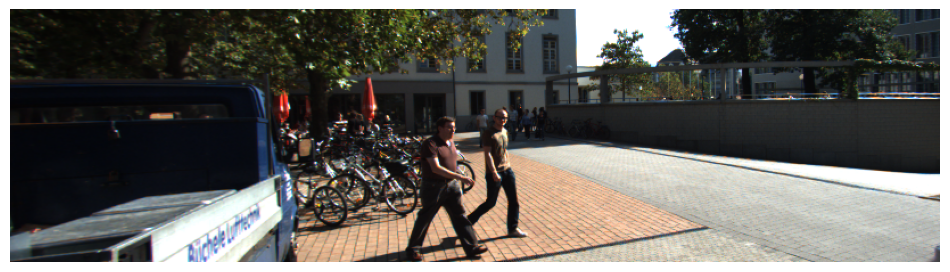

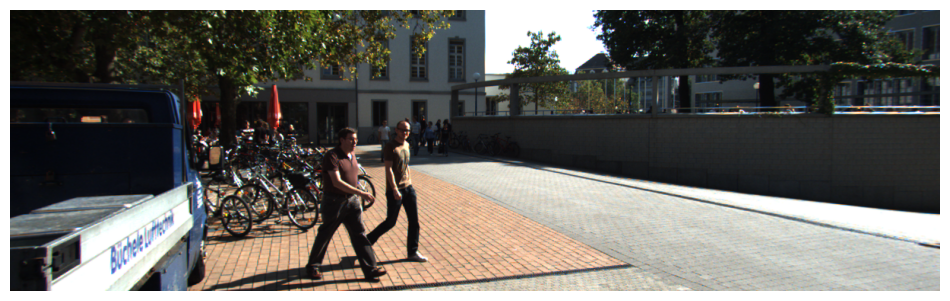

In [12]:
# Path to the image
image_to_rectify_path = r"C:\Users\laura\OneDrive - Danmarks Tekniske Universitet\Dokumenter\AS DTU\FALL 2024 DTU\Perception for Autonomous Systems\Final project\34759_final_project_raw\34759_final_project_raw\seq_01\image_02\data\0000000000.png"
reference_image_path = r"C:\Users\laura\OneDrive - Danmarks Tekniske Universitet\Dokumenter\AS DTU\FALL 2024 DTU\Perception for Autonomous Systems\Final project\34759_final_project_rect\34759_final_project_rect\seq_01\image_02\data\000000.png"
# Load the image
img_to_rectify = cv2.imread(image_to_rectify_path)
reference_img = cv2.imread(reference_image_path)

# Ensure the image dimensions match those used for calibration
if img_to_rectify.shape[:2][::-1] != img_size_2:
    raise ValueError("The image size does not match the size used during calibration.")

# Create the rectification maps
map1x, map1y = cv2.initUndistortRectifyMap(K2, D2, R2, P2, img_size_2, cv2.CV_32F)
map2x, map2y = cv2.initUndistortRectifyMap(K3, D3, R3, P3, img_size_2, cv2.CV_32F)

# Apply rectification
rectified_img = cv2.remap(img_to_rectify, map1x, map1y, cv2.INTER_LINEAR)

# Crop the rectified image using the region of interest (roi1)
x, y, w, h = roi1
rectified_img_cropped = rectified_img[y:y+h, x:x+w]

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(rectified_img_cropped, cv2.COLOR_BGR2RGB))
#plt.title("Rectified Image")
plt.axis("off")
plt.show()

# Display reference image
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB))
#plt.title("Reference Image")
plt.axis("off")
plt.show()


# # # Save the rectified image
# # output_path = os.path.join(base_path, "rectified_image.png")
# # cv2.imwrite(output_path, rectified_img)
# # print(f"Rectified image saved at: {output_path}")

# # Display the images side by side
# plt.figure(figsize=(12, 6))

# # Show rectified image
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(rectified_img_cropped, cv2.COLOR_BGR2RGB))
# plt.title("Rectified Image")
# plt.axis("off")

# # Show reference image
# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB))
# plt.title("Reference Image")
# plt.axis("off")

# plt.show()

# # Compare the original and rectified images
# plt.figure(figsize=(12, 6))

# # Show original image
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(img_to_rectify, cv2.COLOR_BGR2RGB))
# plt.title("Original Image")
# plt.axis("off")

# # Show rectified image
# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(rectified_img_cropped, cv2.COLOR_BGR2RGB))
# plt.title("Rectified Image")
# plt.axis("off")

# plt.show()

